<a href="https://colab.research.google.com/github/shubhamrai1318/Recommendation_System_for_E-commerce/blob/main/Recommendation_For_Ecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation System for E-commerce**

## **Importing libraries**


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

## **Loading Dataset**

In [2]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the Dataset
file_path = '/content/drive/MyDrive/Shubham/CsvFiles/ratings_Electronics.csv'
df = pd.read_csv(file_path)

## **Data Manipulation**

In [4]:
df

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [5]:
# Adding Column Names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [6]:
#Dropping timestamp
df = df.drop('timestamp', axis=1)

In [7]:
# Rows and Columns of Dataset
rows, columns = df.shape
print("There are", rows , "Rows")
print("There are", columns,"Columns")

There are 7824481 Rows
There are 3 Columns


In [8]:
# Datatypes of Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [9]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [10]:
# Summary statistics of 'rating' variable
df.describe()

,rating
count,7.824481e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [11]:
#Finding the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


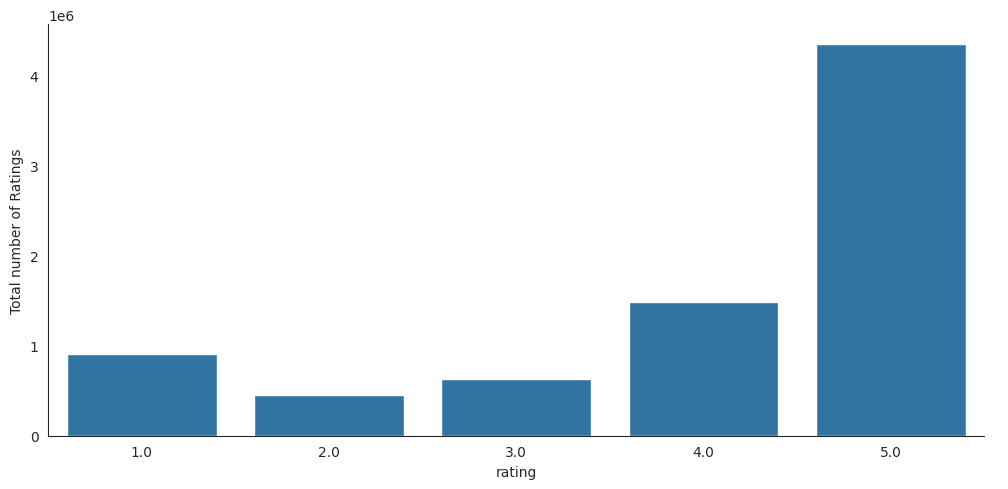

In [12]:
# Checking the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of Ratings")


In [13]:
# Number of unique user id  in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique PRODUCTS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476001


In [16]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
dtype: int64

## Preprocessing

In [22]:
counts=df.user_id.value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]
print('Number of users who have rated 25 or more items =', len(df_final))
print('Number of unique users in the final data = ', df_final['user_id'].nunique())
print('Number of unique products in the final data = ', df_final['prod_id'].nunique())

Number of users who have rated 25 or more items = 125871
Number of unique users in the final data =  1540
Number of unique products in the final data =  48190


## **Rating Analysis of Final Dataset**

In [24]:
# Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

# Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

# Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


## **Rank Based Recommendation System**

In [25]:
# Calculating the average rating and count of ratings for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
count_rating = df_final.groupby('prod_id')['rating'].count()

In [26]:
# Creating a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [27]:
# Sort the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

In [28]:
# Display the top-rated products
top_rated_products = final_rating.head()
print(top_rated_products)

            avg_rating  rating_count
prod_id                             
0594451647         5.0             1
B003RRY9RS         5.0             1
B003RR95Q8         5.0             1
B003RIPMZU         5.0             1
B003RFRNYQ         5.0             2


### **Creating Fuction to get the top n products based on highest average rating and minimum interactions**

In [31]:
def get_top_n_products(final_ratings_df, num_products, min_interaction_count):
    # Checking if the final_ratings_df DataFrame is empty or not
    if final_ratings_df.empty:
        print("Error: The final_ratings_df DataFrame is empty.")
        return []

    # Checking if num_products is greater than the number of available products or not
    if num_products > len(final_ratings_df):
        print("Warning: Requested number of top products is greater than the number of available products.")
        num_products = len(final_ratings_df)

    # Filtering products with the minimum number of interactions
    recommended_products = final_ratings_df[final_ratings_df['rating_count'] > min_interaction_count]

    # Checking if there are products with the required number of interactions
    if recommended_products.empty:
        print(f"Error: No products with at least {min_interaction_count} interactions found.")
        return []

    # Sorting values based on average rating in descending order
    recommended_products = recommended_products.sort_values('avg_rating', ascending=False)

    # Checking if there are enough products to fulfill the request
    if num_products > len(recommended_products):
        print(f"Warning: Requested number of top products is greater than the number of products with at least {min_interaction_count} interactions.")
        num_products = len(recommended_products)

    # Returning the top n product IDs
    return recommended_products.index[:num_products].tolist()

### **Creating Function for Printing the top n products based on highest average rating and minimum interactions**

In [32]:
# Example usage of the function with additional checks
top_products_50_interactions = get_top_n_products(final_rating, 5, 50)
top_products_100_interactions = get_top_n_products(final_rating, 10, 100)

def print_top_products(products, n, min_interactions):
    if not products:
        print(f"Error: No top products with at least {min_interactions} interactions were found.")
    else:
        print(f"Top {n} products with at least {min_interactions} interactions:")
        for i, product in enumerate(products, start=1):
            print(f"{i}. Product ID: {product}")

### **Recommending top 5 Products with 50 Interactions with the help of *print_top_products* Function**


In [38]:
# Printing results of top 5 products with at least 50 interactions:
print_top_products(top_products_50_interactions, 5, 50)

Top 5 products with at least 50 interactions:
1. Product ID: B001TH7GUU
2. Product ID: B003ES5ZUU
3. Product ID: B0019EHU8G
4. Product ID: B006W8U2MU
5. Product ID: B000QUUFRW


### **Recommending top 10 Products with 100 Interactions with 50 Interactions with the help of *print_top_products* Function**

In [37]:
# Printing results of top 10 products with at least 100 interactions:
print_top_products(top_products_100_interactions, 10, 100)

Top 10 products with at least 100 interactions:
1. Product ID: B003ES5ZUU
2. Product ID: B000N99BBC
3. Product ID: B007WTAJTO
4. Product ID: B002V88HFE
5. Product ID: B004CLYEDC
6. Product ID: B00834SJSK
7. Product ID: B0034CL2ZI
8. Product ID: B00834SJNA
9. Product ID: B00829TIEK
10. Product ID: B00829THK0
